**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Dirichlet BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [Problem conditions](#whatisit)
* [Definitions](#defs)
* [Setup](#setup)
* [Test](#test)
---

## [Problem conditions](#toc)<a id='whatisit'></a>

A constant thermal conductivity with a constant source are used with temperature enforced on both ends of the domain. Namely,

 + $k(x) = 31 \left [ \frac{W}{mK} \right ]$
 + $f(x)=156940\; \left [ \frac{W}{m^{3}} \right ]$
 + $T(a)=20$ [°C], and $T(b)=40$ [°C]

respectively.

## [Definition of the necessary functions](#toc)<a id="defs"></a>

In [1]:
'''Generate the target function f'''
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

## [Setup](#toc)<a id="setup"></a>

In [2]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min=0
x_max=0.05

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [3]:
'''Domain partition'''
from pyfires import get_domain_partition

In [4]:
'''Parent mapping'''
from pyfires import get_parent_mapping

In [5]:
'''The basis functions'''
from pyfires import get_parent_basis_functions

In [6]:
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function

In [7]:
'''All global basis functions'''
from pyfires import get_global_basis_functions

In [8]:
'''Pedagogical inner product'''
from pyfires import inner_product

## [Test](#toc)<a id="test"></a>

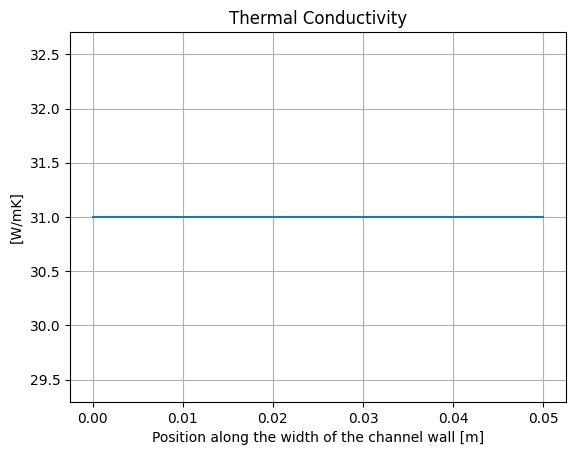

In [17]:
'''Parameters'''
'''Thermal conductivity'''
cond_shape_pts = [(0,31), (0.05,31)]
cond = np.array(cond_shape_pts)

f_cond = interp1d(cond[:,0], cond[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200), f_cond(np.linspace(0,0.05,200)), label='Target Function')
plt.title('Thermal Conductivity')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("[W/mK]")
plt.grid()
plt.show()

The thermal conductivity graph is here to demonstrate that the value for thermal conductivty remains constant as you move between points a and b through the brick. 

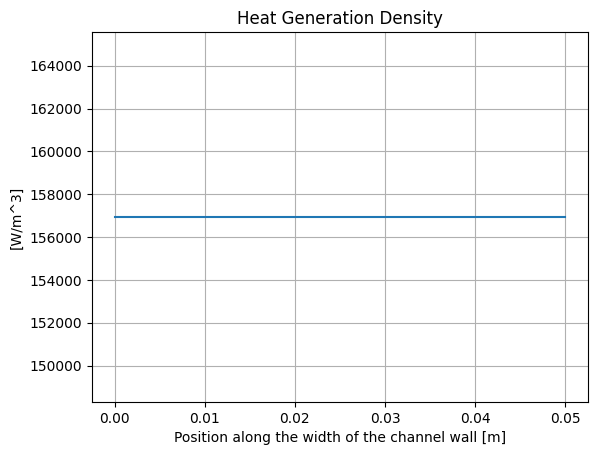

In [20]:
'''Source bias'''
#Use of points to build the source bias function

source_shape_pts = [(0,156940), (0.05,156940)]
source = np.array(source_shape_pts)

f_sourcebias = interp1d(source[:,0], source[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200), f_sourcebias(np.linspace(0,0.05,200)), label='Target Function')
plt.title('Heat Generation Density')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("[W/m^3]")
plt.grid()
plt.show()

The heat generation density graph is here to demonstrate that the value for the heat generation denisty remains constant through points a and b in the brick. 

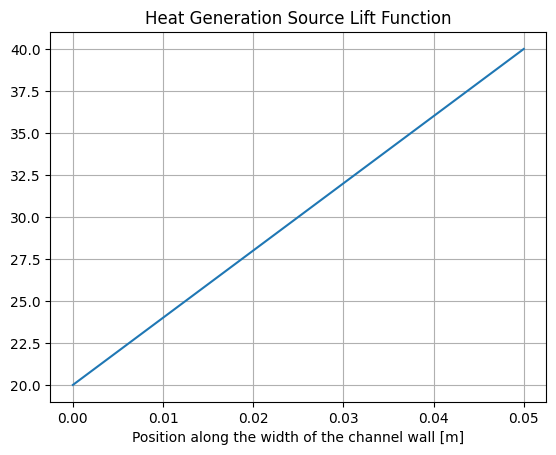

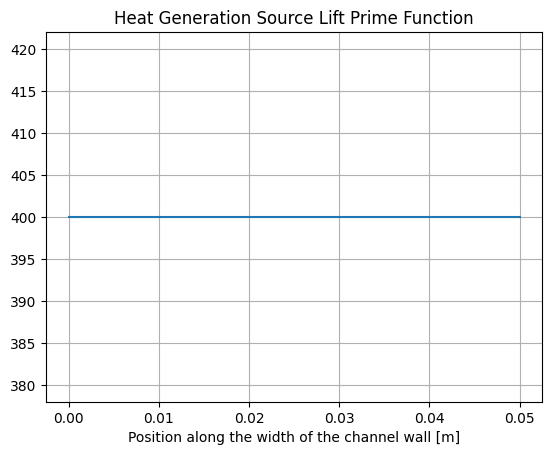

In [22]:
'''Data (boundary conditions for testing purposes)'''
'''Building the lift function'''
u_a = 20 # C
u_b = 40 # C

lift_shape_pts = [(0,u_a), (0.05,u_b)]
lift = np.array(lift_shape_pts)
f_lift = interp1d(lift[:,0], lift[:,1])

f_prime=((u_b-u_a)/(x_max-x_min))
lift_prime_shape_pts = [(0,f_prime), (0.05,f_prime)]
lift_prime = np.array(lift_prime_shape_pts)
f_lift_prime = interp1d(lift_prime[:,0], lift_prime[:,1])

plt.figure()
plt.plot(np.linspace(0,0.05,200), f_lift(np.linspace(0,0.05,200)))
plt.title('Heat Generation Source Lift Function')
plt.xlabel("Position along the width of the channel wall [m]")
plt.grid()
plt.show()

plt.figure()
plt.plot(np.linspace(0,0.05,200), f_lift_prime(np.linspace(0,0.05,200)))
plt.title('Heat Generation Source Lift Prime Function')
plt.xlabel("Position along the width of the channel wall [m]")
plt.grid()
plt.show()

In [23]:
'''FEM Solution'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [24]:
#Building of the A matrix
A_mtrx = np.zeros((len(phi_list), len(phi_list)), dtype=np.float64)
patches = domain_partition[0]
for i in range(len(phi_list)):
    for j in range(len(phi_list)):
        
        phi_i=phi_list[i]
        phi_j=phi_list[j]
        
        phi_prime_i=phi_prime_list[i]
        phi_prime_j=phi_prime_list[j]
        
        h_e=(x_max-x_min)/n_elem
        
        d_x_phi_prime_j = lambda x: f_cond(x) * ((2/h_e)*phi_prime_j(x))
        
        prima = lambda x: phi_prime_i(x)*(2/h_e)
        
        A_mtrx[i,j] = inner_product(prima, d_x_phi_prime_j, patches)

In [25]:
'''Build load vector'''
#The load vector
b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]

for i in range(len(phi_list)):
    phi_i=phi_list[i]
    phi_prime_i=phi_prime_list[i]
    
    b_vec[i] = inner_product(f_sourcebias, phi_i, patches)
    
    first_term = lambda x: f_lift_prime(x)*f_cond(x)
    phi_prima_i = lambda x: phi_prime_i(x)*(2/h_e)
    
    b_vec[i] -= inner_product(first_term, phi_prima_i, patches)

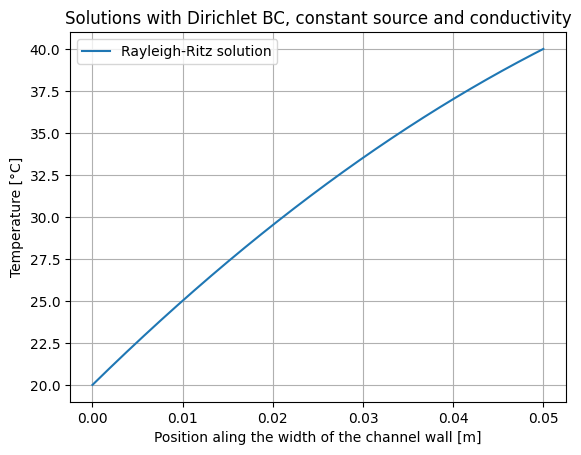

/tmp/ipykernel_7984/2406635048.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
/tmp/ipykernel_7984/2406635048.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))


The value of the function at the leftmost end of the domain is: 20.00 [°C].
The value of the function at the rightmost end of the domain is: 40.00 [°C].


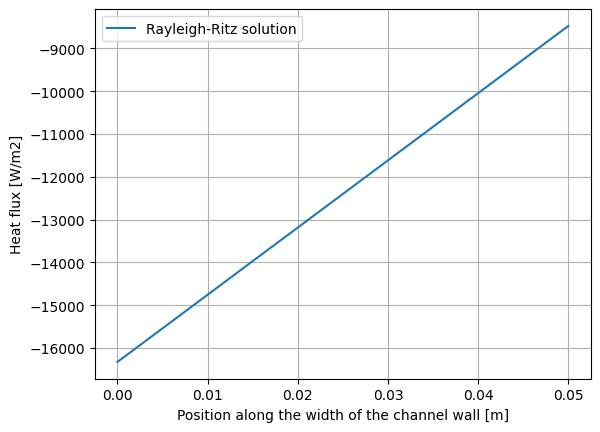

q_na computed =  [-16323.5]
q_nb computed =  [-8476.5]


In [26]:
'''Solution'''
'''Compute optimal coefficient vector'''
c_star_vec = np.linalg.solve(A_mtrx, b_vec)

'''Plot comparison of f and g_best_vec'''
def u_star(x):
    g_x=f_lift(x)
    for (j,phi_i) in enumerate(phi_list):
        g_x=g_x+(c_star_vec[j])*phi_i(x)
    return g_x

def u_star_prime(x):
    g_x=f_lift_prime(x)
    for j in range(len(phi_list)):
        g_x=g_x+(c_star_vec[j])*((2/h_e)*phi_prime_list[j](x))
    return g_x

plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),u_star(np.linspace(x_min,x_max,2000)),label='Rayleigh-Ritz solution')

#plt.plot(np.linspace(x_min,x_max,2000),sol(np.linspace(x_min,x_max,2000)),label='Analytic solution')
plt.title('Solutions with Dirichlet BC, constant source and conductivity')
plt.xlabel("Position aling the width of the channel wall [m]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()

print('The value of the function at the leftmost end of the domain is: %4.2f [°C].'%u_star(x_min))
print('The value of the function at the rightmost end of the domain is: %4.2f [°C].'%u_star(x_max))

#Plotting the flux
plt.figure()
plt.plot(np.linspace(x_min,x_max,2000),-f_cond(np.linspace(x_min,x_max,2000))*u_star_prime((np.linspace(x_min,x_max,2000))),label='Rayleigh-Ritz solution')
plt.xlabel("Position along the width of the channel wall [m]")
plt.ylabel("Heat flux [W/m2]")
plt.legend()
plt.grid()
plt.show()

'''Flux at boundary'''
print('q_na computed = ', -f_cond(x_min)*u_star_prime(x_min))
print('q_nb computed = ', -f_cond(x_max)*u_star_prime(x_max))